In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product
import math
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
import graphviz 

import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md
import credit_util as crd

sns.set(style = "ticks", color_codes = True)
%matplotlib inline 

### Read and Pre-Process Data

#### Read Data

In [2]:
credit_df = ml.retrieve_data(filename = 'data/credit-data.csv', headers = True, set_ind = 0)

In [3]:
credit_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [4]:
# explore statistics of all columns
credit_df.describe().round(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000,41016.000,41016.000,41016.000,41016.000,41016.000,33042.000,41016.000,41016.00,41016.000,41016.000,39979.000
mean,0.161,6.376,51.683,60623.824,0.589,331.458,6578.996,8.403,0.42,1.009,0.372,0.773
std,0.368,221.619,14.747,11.984,5.206,1296.110,13446.826,5.207,5.19,1.154,5.170,1.121
min,0.000,0.000,21.000,60601.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
25%,0.000,0.034,41.000,60618.000,0.000,0.176,3333.000,5.000,0.00,0.000,0.000,0.000
50%,0.000,0.190,51.000,60625.000,0.000,0.370,5250.000,8.000,0.00,1.000,0.000,0.000
75%,0.000,0.667,62.000,60629.000,0.000,0.866,8055.750,11.000,0.00,2.000,0.000,1.000
max,1.000,22000.000,109.000,60644.000,98.000,106885.000,1794060.000,56.000,98.00,32.000,98.000,13.000


In [5]:
# create quick reference for accessing columns
col_ref = ml.create_col_ref(credit_df)
col_ref

{'DebtRatio': 5,
 'MonthlyIncome': 6,
 'NumberOfDependents': 11,
 'NumberOfOpenCreditLinesAndLoans': 7,
 'NumberOfTime30-59DaysPastDueNotWorse': 4,
 'NumberOfTime60-89DaysPastDueNotWorse': 10,
 'NumberOfTimes90DaysLate': 8,
 'NumberRealEstateLoansOrLines': 9,
 'RevolvingUtilizationOfUnsecuredLines': 1,
 'SeriousDlqin2yrs': 0,
 'age': 2,
 'zipcode': 3}

In [6]:
# check column types
credit_df.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
zipcode                                   int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

#### Identify Outliers

In [7]:
  def remove_dramatic_outliers(df, outliers_df, max_min_df, col, threshold):
    outlier_values = list(max_min_df.loc[outliers_df[outliers_df[col] > threshold][col].index, col])
    df[~df[col].isin(outlier_values)]

In [8]:
maxes = ml.view_max_mins(credit_df, max = True)
maxes.tail()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.996,1.0,1.820415,90.0,60644.0,6.0,6530.920,39993.260,28.0,7.000,6.0,4.0,5.0
0.997,1.0,2.054715,91.0,60644.0,9.0,7480.875,45000.000,30.0,10.955,7.0,6.0,5.0
0.998,1.0,3.601156,92.0,60644.0,98.0,8896.110,58305.694,32.0,98.000,8.0,98.0,5.0
0.999,1.0,1760.280000,94.0,60644.0,98.0,11373.160,81840.551,35.0,98.000,10.0,98.0,6.0
1.000,1.0,22000.000000,109.0,60644.0,98.0,106885.000,1794060.000,56.0,98.000,32.0,98.0,13.0


In [9]:
likely_outliers_upper = ml.view_likely_outliers(credit_df)
likely_outliers_upper.tail()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.996,0.0,0.121875,0.011236,0.0,0.000000,0.075482,0.199810,0.037037,0.166667,0.000000,0.333333,0.000000
0.997,0.0,0.128707,0.011111,0.0,0.500000,0.145455,0.125190,0.071429,0.565000,0.166667,0.500000,0.000000
0.998,0.0,0.752630,0.010989,0.0,9.888889,0.189180,0.295682,0.066667,7.945687,0.142857,15.333333,0.000000
0.999,0.0,487.809672,0.021739,0.0,0.000000,0.278442,0.403646,0.093750,0.000000,0.250000,0.000000,0.200000
1.000,0.0,11.498012,0.159574,0.0,0.000000,8.398004,20.921407,0.600000,0.000000,2.200000,0.000000,1.166667


In [10]:
mins = ml.view_max_mins(credit_df, max = False)
mins

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.000,0.0,0.0,21.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.001,0.0,0.0,21.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.002,0.0,0.0,22.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.003,0.0,0.0,22.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.005,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.006,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.007,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.008,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.009,0.0,0.0,24.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
likely_outliers_lower = ml.view_likely_outliers(credit_df, max = False)
likely_outliers_lower

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002,NaN,NaN,0.047619,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.003,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.004,NaN,NaN,0.045455,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.005,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.006,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.007,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.008,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009,NaN,NaN,0.043478,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Revolving utilization of unsecured credit lines should be between 0 and 1
ml.remove_over_threshold(credit_df, col = "RevolvingUtilizationOfUnsecuredLines", value_cutoff = 1)


In [13]:
ml.remove_over_threshold(credit_df, 'DebtRatio', 0.999)

In [14]:
ml.print_null_freq(credit_df)

value                                 False  True 
variable                                          
DebtRatio                             40974     42
MonthlyIncome                         33042   7974
NumberOfDependents                    39979   1037
NumberOfOpenCreditLinesAndLoans       41016      0
NumberOfTime30-59DaysPastDueNotWorse  41016      0
NumberOfTime60-89DaysPastDueNotWorse  41016      0
NumberOfTimes90DaysLate               41016      0
NumberRealEstateLoansOrLines          41016      0
RevolvingUtilizationOfUnsecuredLines  39677   1339
SeriousDlqin2yrs                      41016      0
age                                   41016      0
zipcode                               41016      0


#### Fill Null Values

In [15]:
# fill null values  with basic 
ml.basic_fill_vals(credit_df, "NumberOfDependents", method = "zeros")

In [16]:
ml.basic_fill_vals(credit_df, "MonthlyIncome", method = "mean")

In [17]:
ml.basic_fill_vals(credit_df, "RevolvingUtilizationOfUnsecuredLines", method = "mean")

In [18]:
ml.basic_fill_vals(credit_df, "DebtRatio", method = "mean")

In [19]:
ml.print_null_freq(credit_df)

value                                 False
variable                                   
DebtRatio                             41016
MonthlyIncome                         41016
NumberOfDependents                    41016
NumberOfOpenCreditLinesAndLoans       41016
NumberOfTime30-59DaysPastDueNotWorse  41016
NumberOfTime60-89DaysPastDueNotWorse  41016
NumberOfTimes90DaysLate               41016
NumberRealEstateLoansOrLines          41016
RevolvingUtilizationOfUnsecuredLines  41016
SeriousDlqin2yrs                      41016
age                                   41016
zipcode                               41016


### Explore Data

In [20]:
explore_df = credit_df[credit_df.columns]

#### Feature Distribution

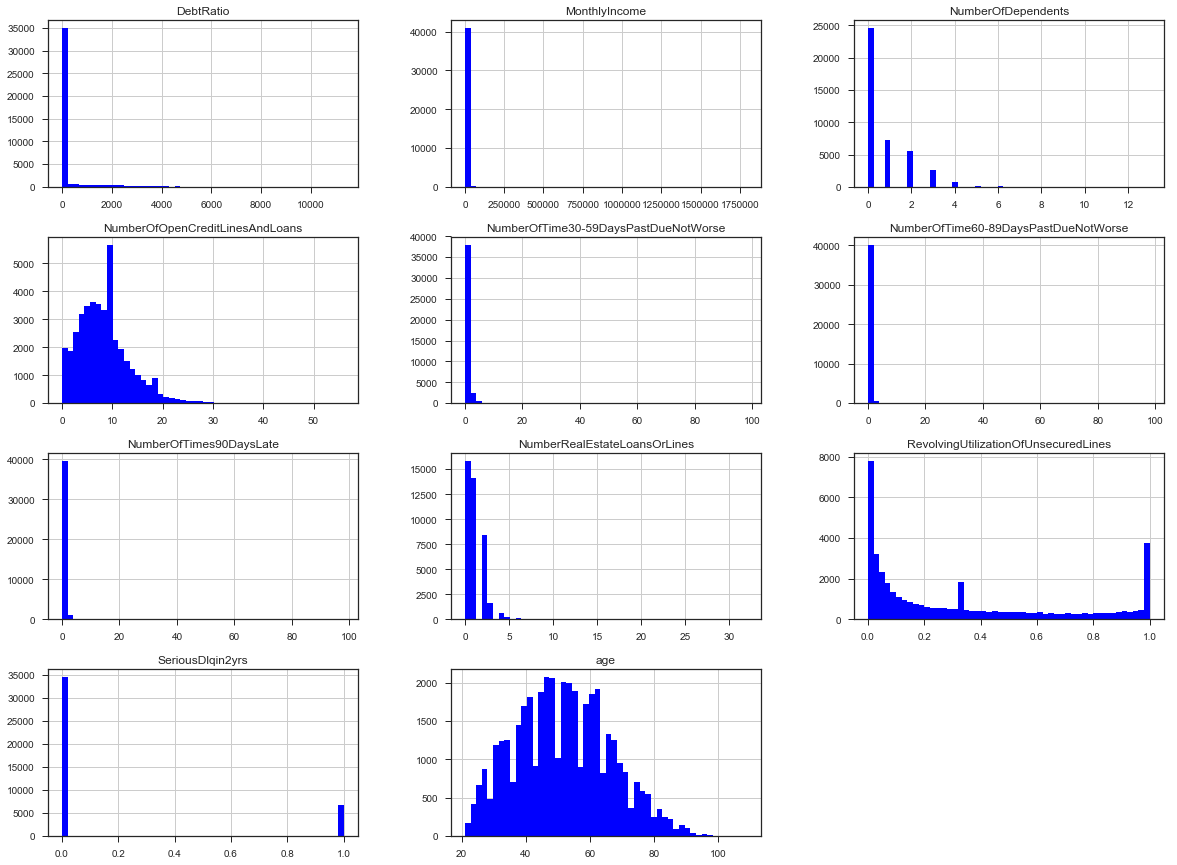

In [21]:
exp.view_dist(explore_df, ["zipcode"])

### Feature Correlation 

#### Pearson Correlation

There appears to be a significant amount of correlation between number of times 30-59 days late, the number of times 60-89 days late, and number of times 90+ days late, that is, a sample who has made a late payment in the 30-60 day window is likely to have also made late payments in the 60-90 day window and 90+ days after due date. As could be expected, the number of real estate loans or lines of credit is correlated with the total number of lines of credit or loans held by a sample. There appears to be relatively low correlation between other predictors.

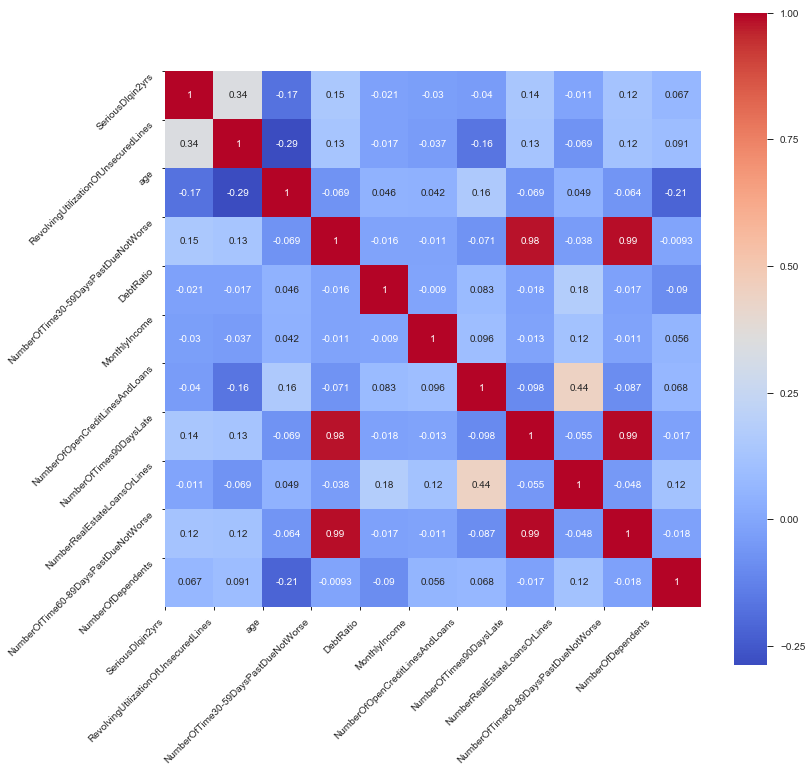

In [22]:
exp.check_corr(explore_df, geo_columns = ["zipcode"])

### Generation of Features/ Predictors and Additional Exploration

#### Discretization of Non-Categorical Variables

In [23]:
exp.discretize_cols(explore_df, ['zipcode'], 7)
explore_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,RevolvingUtilizationOfUnsecuredLines_bin,age_bin,NumberOfTime30-59DaysPastDueNotWorse_bin,DebtRatio_bin,MonthlyIncome_bin,NumberOfOpenCreditLinesAndLoans_bin,NumberOfTimes90DaysLate_bin,NumberRealEstateLoansOrLines_bin,NumberOfTime60-89DaysPastDueNotWorse_bin,NumberOfDependents_bin
PersonID,,,,,,,,,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,...,"(0.9, 1.0]","[50.0, 60.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,...,"(0.4, 0.6]","[70.0, 80.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,...,"(-0.001, 0.1]","[50.0, 60.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,...,"(0.9, 1.0]","[50.0, 60.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(8.0, 16.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,...,"(-0.001, 0.1]","[41.0, 50.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(2.0, 4.0]"


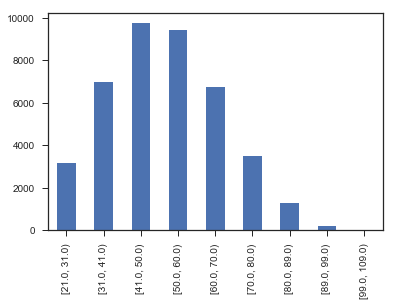

In [24]:
explore_df["age_bin"].value_counts().sort_index().plot(kind='bar')
plt.show()

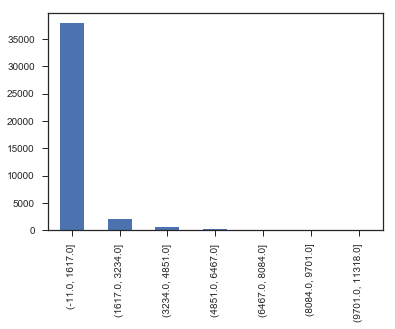

In [25]:
explore_df["DebtRatio_bin"].value_counts().sort_index().plot(kind='bar')
plt.show()

#### Inter-Variable Correlation

In [ ]:
# observe distributions and correlations of features 
def plot_corr(df, geo_columns, color_category):
    non_categoricals = isolate_noncategoricals(df, ret_categoricals = False, geo_cols = geo_columns)
    plot_list = non_categoricals + [color_category]
    corr = sns.pairplot(df[plot_list], hue = color_category, palette = "Set2")

In [ ]:
exp.plot_corr(explore_df, geo_columns = ["zipcode"], color_category = "DebtRatio_bin")

#### Debt Ratio and Credit Utilization Breakdown by Age & Credit Utiliziation Breakdown by Debt Ratio 

Age alone does not appear to be a predicting debt ratio--each grouping of debt ratio appears to be spread fairly evenly across age groups, with most samples concentrated around median debt ratio value just below 0.4%. 

Though there appears to be a slight decline in utilization of credit in older age groups (80 years or older), there are far fewer samples in these age group, which could be influencing results with downward bias. Somewhat surprisingly, a higher debt ratio does not appear to be correlated with higher revolving credit utilization.


In [ ]:
exp.plot_relationship(explore_df, feature_x = 'age', xlabel = 'Age', feature_y = 'DebtRatio', ylabel = 'Debt Ratio', color_cat = 'DebtRatio_bin')

In [ ]:
exp.plot_relationship(explore_df, feature_x = 'age', xlabel = 'Age', feature_y = 'RevolvingUtilizationOfUnsecuredLines', ylabel = 'Revolving Utilization Of Unsecured Lines of Credit')

In [ ]:
exp.plot_relationship(explore_df, feature_x = 'age', xlabel = 'Age', feature_y = 'MonthlyIncome', ylabel = 'Monthly Income', xlimit = (0, None), ylimit = (0, 750000))

In [ ]:
exp.plot_relationship(explore_df, feature_x = 'DebtRatio', xlabel = 'Debt Ratio', feature_y = 'RevolvingUtilizationOfUnsecuredLines', ylabel = 'Revolving Utilization of Unsecured Lines', xlimit = (0, None), ylimit = (0, 1.1))

#### Payment Delinquency Across Age Groups 

In [ ]:
exp.eval_ratios(explore_df, include_cols = ['age_bin', 'SeriousDlqin2yrs'], category_cols = ['age_bin'], method = "sum", pct = True)

In [ ]:
payment_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
crd.payment_grid(explore_df, focus_cols = payment_cols, group_col = 'age_bin')

### Open Credit Lines and Loans Breakdown by Debt Ratio, Age, and Zip Code

For the six zip codes included in sample, the median number of open credit lines majority of persons in the 31-79 age ran is 7-8, with a temporary jump in all zip codes to 9 in the 50-59 decade. only a portion of  samples in age ranges 41-69 had significantly more open lines of credit than other groups, with the vast majority in the 50-59 range. 

#### Number of Samples by Zip Code

In [ ]:
explore_df["zipcode"].value_counts().sort_index().plot(kind='bar')
plt.show()

#### Median Open Credit Lines and Loans by Debt Ratio Bracket Across Zip Codes

In [ ]:
zip_open_credits_median = exp.feature_by_geo(explore_df, geo = 'zipcode', expl_var = ["DebtRatio_bin"], num_var = "NumberOfOpenCreditLinesAndLoans")
zip_open_credits_median

#### Count of Open Credit Lines and Loans by Debt Ratio Bracket Across Zip Codes

In [ ]:
zip_open_credits_count = exp.feature_by_geo(explore_df, 'zipcode', ["DebtRatio_bin"], "NumberOfOpenCreditLinesAndLoans", method = "count")
zip_open_credits_count.transform(lambda x: x/x.sum())

#### Median Open Credit Lines and Loans by Age Group Across Zip Codes

In [ ]:
zip_open_credits_median_age = exp.feature_by_geo(explore_df, 'zipcode', ["age_bin"], "NumberOfOpenCreditLinesAndLoans", method = "median")
zip_open_credits_median_age

#### Count of Open Credit Lines and Loans by Age Group Across Zip Codes

In [ ]:
zip_open_credits_count_age = exp.feature_by_geo(explore_df, 'zipcode', ["age_bin"], "NumberOfOpenCreditLinesAndLoans", method = "count")
zip_open_credits_count_age

#### Dummy Variable Creation

In [ ]:
to_dummy = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
dummy_flags = ['NumberOfTimes', 'NumberOfTime', 'NumberOf']

In [ ]:
exp.create_binary_vars(explore_df, to_dummy, dummy_flags)

In [ ]:
explore_df.head()

#### Monthly Income by Number of Dependents 

In most zip codes, samples with dependents have monthly income \$1200-\$1500 higher than those without. In zip code 60644, this difference i over \$2000.  

In [ ]:
crd.standardized_comparison(explore_df, primary_cols = ['tf_Dependents', 'MonthlyIncome'], group_cols = ['tf_Dependents'])

In [ ]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_Dependents', group_cols = ['zipcode']).reset_index().set_index('zipcode')

#### Delinquent Payments by Montly Income

There appears to be about a \$300 difference in monthly income between samples who heave made a payment between 30 and 59 days late in the last two years and those who did not make late payments, but a \$1200-\$1500 difference between samples who have made payments more than 60 days late. Zip code 60644 is the exception, with differences in monthly income between samples making late payments and those who made none in the multiple thousands of dollars.

In [ ]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_30-59DaysPastDueNotWorse', group_cols = ['zipcode'])

In [ ]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_60-89DaysPastDueNotWorse', group_cols = ['zipcode'])

In [ ]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_90DaysLate', group_cols = ['zipcode'])

### Build and Evaluate Classifier

Using the sklearn decision tree, I built and tested 108 versions of a decision tree model with varying parameters. I used the accuracy score for evaluation (as noted in assignment instructions), and identified the importance of each feature for the most accurate model. Finally, I created a graphic of the most accurate decision tree model.

#### Separate Training and Test Data

In [ ]:
x_train, x_test, y_train, y_test = md.split_data(credit_df, outcome_var = "SeriousDlqin2yrs", geo_columns = ['zipcode'], test_size = 0.25)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

#### Build and Test Decision Tree Models

In [ ]:
# parameters for looping sourced from example at https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None, 'sqrt','log2'],'min_samples_split': [2,5,10]}

In [ ]:
dt_results = md.loop_dt(dt_params, training_predictors = x_train, testing_predictors = x_test, training_outcome = y_train, testing_outcome = y_test)

In [ ]:
dt_results_ordered = dt_results.sort_values('test_acc', ascending = False)
dt_results_ordered.head(20)

In [ ]:
dt_results_ordered.tail(20)

In [ ]:
dec_tree = md.create_best_tree(accuracy_df = dt_results, training_predictors = x_train, training_outcome = y_train)

In [ ]:
md.feature_importance_ranking(dec_tree, training_predictors = x_train)

#### Decision Tree Visual

In [ ]:
md.visualize_best_tree(dec_tree, training_predictors = x_train)